<a href="https://colab.research.google.com/github/ErwinDinata/Website-Personal/blob/main/Erwin_Dinata_4212301024_Machine_Vision_ATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jumlah data asli: (88800, 785)
Total data setelah balancing: 13000

Ekstraksi HOG dengan {'orientations': 12, 'ppc': (4, 4), 'cpb': (3, 3)}


  SVM {'C': 50, 'gamma': 0.001} → Akurasi: 0.5550


  SVM {'C': 100, 'gamma': 0.001} → Akurasi: 0.5700


  SVM {'C': 100, 'gamma': 0.0005} → Akurasi: 0.5550

Ekstraksi HOG dengan {'orientations': 12, 'ppc': (4, 4), 'cpb': (2, 2)}


  SVM {'C': 50, 'gamma': 0.001} → Akurasi: 0.5250


  SVM {'C': 100, 'gamma': 0.001} → Akurasi: 0.5350


  SVM {'C': 100, 'gamma': 0.0005} → Akurasi: 0.5250

Ekstraksi HOG dengan {'orientations': 18, 'ppc': (4, 4), 'cpb': (2, 2)}


  SVM {'C': 50, 'gamma': 0.001} → Akurasi: 0.4850


  SVM {'C': 100, 'gamma': 0.001} → Akurasi: 0.4950


  SVM {'C': 100, 'gamma': 0.0005} → Akurasi: 0.4850

=== Kombinasi Terbaik ===
HOG : {'orientations': 12, 'ppc': (4, 4), 'cpb': (3, 3)}
SVM : {'C': 100, 'gamma': 0.001}
Akurasi Tertinggi: 0.5700


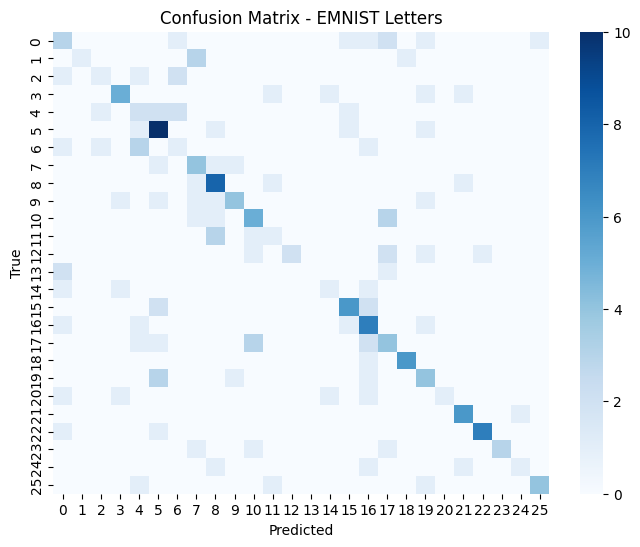

In [3]:

#Nama  : Erwin Dinata
#NIM   : 4212301024
#Kelas : Mekatronika A Malam

# === Import Library Utama ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm

# === 1. Baca Dataset EMNIST ===
df_train = pd.read_csv('emnist-letters-train.csv', header=None)
print("Jumlah data asli:", df_train.shape)

# === 2. Balancing Dataset (ambil 500 sampel per kelas) ===
samples_per_class = 500
balanced_df = pd.concat([
    df_train[df_train[0] == i].sample(samples_per_class, random_state=42, replace=True)
    for i in range(1, 27)
])
print("Total data setelah balancing:", len(balanced_df))

# === 3. Pisahkan fitur dan label ===
y = balanced_df.iloc[:, 0].values
X = balanced_df.iloc[:, 1:].values / 255.0
X_images = X.reshape(-1, 28, 28)

# === 4. Fungsi Ekstraksi Fitur HOG ===
def extract_hog_features(images, orientations=9, ppc=(8, 8), cpb=(2, 2)):
    return np.array([
        hog(img, orientations=orientations,
            pixels_per_cell=ppc, cells_per_block=cpb,
            block_norm='L2-Hys', transform_sqrt=True,
            visualize=False)
        for img in images
    ])

# === 5. Gunakan subset kecil untuk demo ===
X_data, y_data = shuffle(X_images, y, random_state=42)
X_data, y_data = X_data[:200], y_data[:200]

# === 6. Daftar parameter yang diuji ===
hog_params_list = [
    {'orientations': 12, 'ppc': (4, 4), 'cpb': (3, 3)},
    {'orientations': 12, 'ppc': (4, 4), 'cpb': (2, 2)},
    {'orientations': 18, 'ppc': (4, 4), 'cpb': (2, 2)},
]

svm_params_list = [
    {'C': 50, 'gamma': 0.001},
    {'C': 100, 'gamma': 0.001},
    {'C': 100, 'gamma': 0.0005},
]

# === 7. Pencarian Kombinasi Terbaik ===
best_acc = 0
best_combo = {}

for h_params in hog_params_list:
    print(f"\nEkstraksi HOG dengan {h_params}")
    X_hog = extract_hog_features(
        X_data,
        orientations=h_params['orientations'],
        ppc=h_params['ppc'],
        cpb=h_params['cpb']
    )

    for s_params in svm_params_list:
        svm_model = SVC(kernel='rbf', C=s_params['C'], gamma=s_params['gamma'])
        loo = LeaveOneOut()
        y_true, y_pred = [], []

        for train_idx, test_idx in tqdm(loo.split(X_hog), total=len(X_hog), leave=False):
            X_train, X_test = X_hog[train_idx], X_hog[test_idx]
            y_train, y_test = y_data[train_idx], y_data[test_idx]
            svm_model.fit(X_train, y_train)
            y_pred.append(svm_model.predict(X_test)[0])
            y_true.append(y_test[0])

        acc = accuracy_score(y_true, y_pred)
        print(f"  SVM {s_params} → Akurasi: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_combo = {'hog': h_params, 'svm': s_params}

# === 8. Tampilkan Kombinasi Terbaik ===
print("\n=== Kombinasi Terbaik ===")
print("HOG :", best_combo['hog'])
print("SVM :", best_combo['svm'])
print(f"Akurasi Tertinggi: {best_acc:.4f}")

# === 9. Visualisasi Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix - EMNIST Letters')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
